# Use the t-SNE algorithm to visualize learned embeddings

This is a summary of works below
- Dataset: https://www.kaggle.com/grouplens/movielens-20m-dataset/tasks?taskId=597
- Preprocessing: https://www.kaggle.com/colinmorris/movielens-preprocessing
- Model training: https://www.kaggle.com/colinmorris/movielens-spiffy-model
- Investigate the learned embedding: https://www.kaggle.com/colinmorris/exploring-embeddings-with-gensim
- Visualizing embeddings with t-sne: https://www.kaggle.com/colinmorris/visualizing-embeddings-with-t-sne

In [4]:
#!pip install tensorflow-gpu
import tensorflow as tf
from tensorflow import keras

In [5]:
%matplotlib inline
import random
from functools import lru_cache
import os
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sklearn.preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit

### Preprocessing data

#### Preprocessing rating.csv


In [6]:
input_dir = '../movielens/data'
out_dir = '../movielens/movielens_preprocessed'

In [33]:
rating_path = os.path.join(input_dir, 'rating.csv')
df = pd.read_csv(rating_path, usecols=['userId', 'movieId', 'rating'])

# Shuffle with reproducibly and reset index to RangeIndex
df = df.sample(frac=1, random_state=1).reset_index(drop=True)

In [34]:
# Encode target labels with value [0, n_classes-1]
movie_id_encoder = LabelEncoder()
df['movieId'] = movie_id_encoder.fit_transform(df['movieId'])  

# Partitioning train/val  
val_split = .05
n_ratings = len(df)
n_train = math.floor(n_ratings * (1-val_split))
itrain = df.index[:n_train]
ival = df.index[n_train:]

# Add centred target variable df['y']
df['y'] = df['rating'] - df.loc[itrain, 'rating'].mean()
rating_path = os.path.join(out_dir, 'rating.csv')
df.to_csv(rating_path, index=False)

#### Create a mini dataset mini_rating.csv

In [35]:
# only consider popular movies
movie_counts = df.groupby('movieId').size()              # number of rows for each movie
thresh = 1000
pop_movies = movie_counts[movie_counts >= thresh].index  # movieId of popular movies which show in more than $thresh rows
pop_df = df[df.movieId.isin(pop_movies)]                 # rows of popular movies

# take approx 10% of pop_df as a mini dataset
frac = 2 * 10**6 / len(pop_df)  
print(frac)
splitter = GroupShuffleSplit(n_splits=1, test_size=frac, random_state=1)  
splits = splitter.split(pop_df, groups=pop_df.userId)    # movies with same userId should all in the 10% or all in rest
_, mini = next(splits)                                   # mini is the index of 10% of pop_df
mini_df = pop_df.iloc[mini].copy()                       # mini dataset
print(
    '{:,}'.format(len(mini_df)),
    len(df.userId.unique()) // 1000,
    len(pop_df.userId.unique()) // 1000,
    len(mini_df.userId.unique()) // 1000,
    sep='\n',
)

0.11257764761800333
2,027,645
138
138
15


In [36]:
# Encode col with value [0, df.col.unique-1]
def compactify_ids(df, col, backup=True):    
    encoder = LabelEncoder()   
    if backup:
        df[col+'_orig'] = df[col]
    df[col] = encoder.fit_transform(df[col])
    
for col in ['movieId', 'userId']:
    compactify_ids(mini_df, col, backup=col=='movieId')
    
# Shuffle the mini dataset
mini_df = mini_df.sample(frac=1, random_state=1)

In [37]:
# Partitioning train/val on the mini dataset
val_split = .05
n_mini_train = math.floor(len(mini_df) * (1-val_split))

# re-centre target variable mini_df['y']
mini_train_rating_mean = mini_df.iloc[:n_mini_train]['rating'].mean()
mini_df['y'] = mini_df['rating'] - mini_train_rating_mean

In [38]:
mini_rating_path = os.path.join(out_dir, 'mini_rating.csv')    
mini_df.to_csv(mini_rating_path, index=False)

print(
    df.userId.max(), mini_df.userId.max(),
    '\n',
    df.movieId.max(), mini_df.movieId.max(),
    '\n',
)

df.head()

138493 15591 
 26743 3158 



,userId,movieId,rating,y
0,123425,525,4.0,0.474498
1,108287,930,5.0,1.474498
2,109381,4085,4.0,0.474498
3,64404,892,4.5,0.974498
4,137309,1683,2.5,-1.025502


#### Preprocessing movie.csv

In [39]:
movie_path = os.path.join(input_dir, 'movie.csv')
movie_df = pd.read_csv(movie_path)
mdf = movie_df

# hack
assert mdf.loc[mdf.movieId==64997,'title'].iloc[0] == 'War of the Worlds (2005)'
mdf.loc[mdf.movieId==64997, 'title'] = 'War of the Worlds (2005)x'
 
n_orig = len(mdf)

# Drop movies without ratings in rating.csv
whitelist = set(movie_id_encoder.classes_)                           # Set of all movie_ids from rating.csv
mdf = mdf[mdf['movieId'].isin(whitelist)].copy()
print("Went from {} movies to {} after filtering out movies with no ratings".format(
    n_orig, len(mdf)
))

# Sort by movieId
mdf['movieId'] = movie_id_encoder.transform(mdf['movieId'].values)   # Endode movieIds
mdf = mdf.sort_values(by='movieId')
mdf = mdf.reset_index(drop=True)   


Went from 27278 movies to 26744 after filtering out movies with no ratings


In [40]:
def munge_title(title):
    i = title.rfind(' (')   # index of last occurrence of ' ('
    if i != -1:             # found occurrence of ' ('
        title = title[:i]
    for suff_word in ['The', 'A', 'An']:
        suffix = ', {}'.format(suff_word)
        if title.endswith(suffix):
            title = suff_word + ' ' + title[:-len(suffix)]
    return title
        
def get_year(title):
    l = title.rfind('(') + 1
    try:
        return int(title[l:l+4])
    except ValueError:
        print(title, end='\t') # error when title does not contain year, year = 0
        return 0
    
mdf['key'] = mdf['title']
mdf['year'] = mdf['title'].map(get_year)
mdf['title'] = mdf['title'].map(munge_title)  # remove (year) from title 

Babylon 5	Millions Game, The (Das Millionenspiel)	Bicycle, Spoon, Apple (Bicicleta, cullera, poma)	Brazil: In the Shadow of the Stadiums	Slaying the Badger	Tatort: Im Schmerz geboren	National Theatre Live: Frankenstein	The Court-Martial of Jackie Robinson	In Our Garden	Stephen Fry In America - New World	Two: The Story of Roman & Nyro	Li'l Quinquin	A Year Along the Abandoned Road	Body/Cialo	Polskie gówno	The Third Reich: The Rise & Fall	My Own Man	Moving Alan	Michael Laudrup - en Fodboldspiller	

In [41]:
# reset key with unique title
title_counts = mdf.groupby('title').size()
unique_titles = title_counts.index[title_counts == 1]
unique_ids = mdf.index[mdf.title.isin(unique_titles)]      # index of rows with titles that are unique
mdf.loc[unique_ids, 'key'] = mdf.loc[unique_ids, 'title']  # set unique title to be the key, so that the year are removed

In [42]:
# Add variable mdf['n_ratings'] and mdf['mean_rating']
mdf['n_ratings'] = df.groupby('movieId').size()       # number of ratings for each movieId from rating.csv
mean_ratings = df.groupby('movieId')['rating'].mean() # mean rating of each movieId
mdf['mean_rating'] = mean_ratings


In [43]:
movies_path = os.path.join(out_dir, 'movie.csv')
mdf.to_csv(movies_path)

mdf.head()


,movieId,title,genres,key,year,n_ratings,mean_rating
0,0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995,49695,3.921240
1,1,Jumanji,Adventure|Children|Fantasy,Jumanji,1995,22243,3.211977
2,2,Grumpier Old Men,Comedy|Romance,Grumpier Old Men,1995,12735,3.151040
3,3,Waiting to Exhale,Comedy|Drama|Romance,Waiting to Exhale,1995,2756,2.861393
4,4,Father of the Bride Part II,Comedy,Father of the Bride Part II,1995,12161,3.064592


### Model training to learn embeddings
Train a model which uses:
- matrix factorization architecture
- embedding size = 32
- embedding L2 penalty
- dropout (applied to embedding vectors)
- feaures: 'userId', 'movieId', 'rating', that is, models learn from data points like "user 5299 gave movie 806 a rating of 4.5".

In [6]:
# input
# rating_path = os.path.join(out_dir, 'rating.csv')    
df = pd.read_csv(rating_path, usecols=['userId', 'movieId', 'rating', 'y'])

# random seed
tf.random.set_seed(1); np.random.seed(1); random.seed(1)

# model init
movie_embedding_size = user_embedding_size = 32
user_id_input = keras.Input(shape=(1,), name='user_id')
movie_id_input = keras.Input(shape=(1,), name='movie_id')
movie_r12n = keras.regularizers.l1_l2(l1=0, l2=1e-6)
user_r12n = keras.regularizers.l1_l2(l1=0, l2=1e-7)
dropout = .2

In [7]:
# model arch
user_embedded = keras.layers.Embedding(df.userId.max()+1, user_embedding_size,
                                       embeddings_regularizer=user_r12n,
                                       input_length=1, name='user_embedding')(user_id_input)

user_embedded = keras.layers.Dropout(dropout)(user_embedded)

movie_embedded = keras.layers.Embedding(df.movieId.max()+1, movie_embedding_size, 
                                        embeddings_regularizer=movie_r12n,
                                        input_length=1, name='movie_embedding')(movie_id_input)

movie_embedded = keras.layers.Dropout(dropout)(movie_embedded)

dotted = keras.layers.Dot(2)([user_embedded, movie_embedded])

out = keras.layers.Flatten()(dotted)

In [ ]:
# model training

tf.random.set_seed(1); np.random.seed(1); random.seed(1)

model = keras.Model(
    inputs = [user_id_input, movie_id_input],
    outputs = out,
)

model.summary()

In [8]:
model.compile(
    tf.optimizers.Adam(0.001),
    loss='MSE',
    metrics=['MAE'],
)

model.fit(
    [df.userId, df.movieId],
    df.y,
    batch_size=10**4,
    epochs=30,
    verbose=2,
    validation_split=.05,
);

Epoch 1/30


/home/u32/fanluo/.local/lib/python3.5/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1901/1901 - 40s - loss: 0.9205 - MAE: 0.7457 - val_MAE: 0.6572 - val_loss: 0.7498
Epoch 2/30
1901/1901 - 39s - loss: 0.7322 - MAE: 0.6481 - val_MAE: 0.6342 - val_loss: 0.7079
Epoch 3/30
1901/1901 - 41s - loss: 0.7007 - MAE: 0.6314 - val_MAE: 0.6224 - val_loss: 0.6864
Epoch 4/30
1901/1901 - 41s - loss: 0.6814 - MAE: 0.6213 - val_MAE: 0.6151 - val_loss: 0.6734
Epoch 5/30
1901/1901 - 41s - loss: 0.6682 - MAE: 0.6142 - val_MAE: 0.6102 - val_loss: 0.6647
Epoch 6/30
1901/1901 - 41s - loss: 0.6582 - MAE: 0.6088 - val_MAE: 0.6064 - val_loss: 0.6584
Epoch 7/30
1901/1901 - 41s - loss: 0.6505 - MAE: 0.6046 - val_MAE: 0.6035 - val_loss: 0.6537
Epoch 8/30
1901/1901 - 41s - loss: 0.6444 - MAE: 0.6011 - val_MAE: 0.6014 - val_loss: 0.6503
Epoch 9/30
1901/1901 - 41s - loss: 0.6395 - MAE: 0.5983 - val_MAE: 0.5996 - val_loss: 0.6477
Epoch 10/30
1901/1901 - 41s - loss: 0.6357 - MAE: 0.5961 - val_MAE: 0.5983 - val_loss: 0.6458
Epoch 11/30
1901/1901 - 41s - loss: 0.6324 - MAE: 0.5940 - val_MAE: 0.5973 - val

In [9]:
# model saving
model.save('movie_svd_model_32.h5')

### Investigate the learned embedding

In [7]:
model = keras.models.load_model('movie_svd_model_32.h5')

In [8]:
# get embedding matrix of all movies
emb_layer = model.get_layer('movie_embedding')
(w,) = emb_layer.get_weights()  

print(w)
w.shape 
# w.shape[1] is embeddig size: 32
# w.shape[0] = df.movieId.max() + 1
# w.shape[0] * w.shape[1] = 855808  (Param #)     

[[-3.8504764e-01  4.9484497e-01  2.6502994e-01 ...  1.4734694e-01
   9.0155594e-02  2.5490984e-01]
 [-5.1781708e-01  5.5744803e-01 -3.4039977e-01 ...  2.3290493e-01
   1.7813419e-01  9.4825132e-03]
 [-2.6867318e-01  1.7446106e-02 -4.3704844e-01 ... -6.3677388e-01
   1.5194063e-01 -1.6873764e-01]
 ...
 [-4.1536880e-03 -3.7166311e-23 -1.3906920e-02 ... -6.5984140e-04
   1.3020667e-03 -4.6309291e-05]
 [-1.1146894e-05 -3.7776116e-10 -4.0985555e-08 ... -6.1337055e-08
   4.6885006e-07 -1.4741115e-20]
 [-1.4086484e-03  6.4841006e-04 -3.2797190e-03 ...  6.3530466e-04
   7.5431904e-05  8.5659064e-03]]


(26744, 32)

In [9]:
movies_path = os.path.join(out_dir, 'movie.csv')
mdf = pd.read_csv(movies_path, index_col=0)

mdf.head()

,movieId,title,genres,key,year,n_ratings,mean_rating
0,0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995,49695,3.921240
1,1,Jumanji,Adventure|Children|Fantasy,Jumanji,1995,22243,3.211977
2,2,Grumpier Old Men,Comedy|Romance,Grumpier Old Men,1995,12735,3.151040
3,3,Waiting to Exhale,Comedy|Drama|Romance,Waiting to Exhale,1995,2756,2.861393
4,4,Father of the Bride Part II,Comedy,Father of the Bride Part II,1995,12161,3.064592


#### Vector similarity / distance 
Look at how close or distant pairs of movies are in the embedding space.
- Euclidean Distance
- Cosine Distance<br>
When judging the similarity of embeddings, it's more common to use cosine similarity. <br> 
The cosine similarity of two vectors ranges from -1 to 1. <br> 
Cosine distance = 1 - cosine similarity (therefore ranges from 0 to 2).

In [10]:
# Get the embeddings of a pair of similar movies (Toy Story and Shrek) 
i_toy_story = mdf.loc[mdf.title == 'Toy Story','movieId'].iloc[0]
i_shrek = mdf.loc[mdf.title == 'Shrek','movieId'].iloc[0]
toy_story_vec = w[i_toy_story]
shrek_vec = w[i_shrek]

In [12]:
# calculate the euclidean distance between the embedding vectors of a pair of similar movies 
from scipy.spatial import distance
distance.euclidean(toy_story_vec, shrek_vec)

1.4802277088165283

In [14]:
# calculate the euclidean distance between a pair of movies that we would think of as very different (Toy Story and The Exorcist)
i_exorcist = mdf.loc[mdf.title == 'The Exorcist', 'movieId'].iloc[0]
exorcist_vec = w[i_exorcist]

distance.euclidean(toy_story_vec, exorcist_vec)

2.4868669509887695

In [16]:
# calculate the cosine distance between the embedding vectors of a pair of similar movies 
distance.cosine(toy_story_vec, shrek_vec)

0.3354009985923767

In [17]:
# calculate the cosine distance  between a pair of movies that we would think of as very different (Toy Story and The Exorcist)
distance.cosine(toy_story_vec, exorcist_vec)

0.8627587109804153

#### Exploring embeddings with Gensim

### Visualizing embeddings with t-sne

In [8]:
# To only visualize movies with number of ratings meet some popularity threshold, allowing the model did learn meanful embeddings
threshold = 100
mainstream_movies = mdf[mdf.n_ratings >= threshold].reset_index(drop=True)
print("Went from {} to {} movies after applying threshold".format(
    len(mdf), len(mainstream_movies),
))
print(mainstream_movies.movieId.max())
mainstream_movies.info()

Went from 26744 to 8546 movies after applying threshold
24934
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8546 entries, 0 to 8545
Data columns (total 7 columns):
movieId        8546 non-null int64
title          8546 non-null object
genres         8546 non-null object
key            8546 non-null object
year           8546 non-null int64
n_ratings      8546 non-null int64
mean_rating    8546 non-null float64
dtypes: float64(1), int64(3), object(3)
memory usage: 467.4+ KB


In [9]:
# get embedding matrix of mainstream_movies
w_full = w
w = w[mainstream_movies.movieId]
w

array([[-0.38504764,  0.49484497,  0.26502994, ...,  0.14734694,
         0.09015559,  0.25490984],
       [-0.5178171 ,  0.557448  , -0.34039977, ...,  0.23290493,
         0.17813419,  0.00948251],
       [-0.26867318,  0.01744611, -0.43704844, ..., -0.6367739 ,
         0.15194063, -0.16873764],
       ...,
       [-0.19400989, -0.05943494, -0.10035145, ...,  0.03639452,
         0.3066152 ,  0.31720805],
       [-0.28937787, -0.09271663, -0.277181  , ...,  0.04535266,
         0.22401763,  0.23085795],
       [-0.15082707,  0.01007708, -0.1583271 , ...,  0.10392636,
        -0.01291763, -0.03825183]], dtype=float32)

In [10]:
df = mainstream_movies

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=1, n_iter=15000, metric="cosine")   # take about an hour
embs = tsne.fit_transform(w)

In [15]:
embs[:5]

array([[-100.31754 ,  -29.516657],
       [  20.76603 , -132.11197 ],
       [  65.842476,  -50.610844],
       [  12.194196, -109.0004  ],
       [ -62.63526 , -112.6728  ]])

In [11]:
# Add to dataframe for convenience
df['x'] = embs[:, 0]
df['y'] = embs[:, 1]

In [12]:
df.describe()

,movieId,year,n_ratings,mean_rating,x,y
count,8546.00000,8546.000000,8546.000000,8546.000000,8546.000000,8546.000000
mean,6669.23824,1991.401591,2305.906974,3.298390,0.114872,2.406752
std,5349.70365,18.163421,5121.761350,0.514357,46.189442,80.034630
min,0.00000,1902.000000,100.000000,0.837321,-105.994705,-143.039368
25%,2472.25000,1985.000000,227.000000,2.993341,-35.568382,-68.866291
50%,5227.50000,1996.000000,559.000000,3.388123,-0.887683,2.692298
75%,9982.00000,2004.000000,1851.500000,3.686500,34.815471,70.586086
max,24934.00000,2015.000000,67310.000000,4.446990,115.505753,161.324966


In [ ]:
df.head()

In [13]:
df.to_csv('movies_tsne.csv')   # save the 2d coordinates from t-sne to file

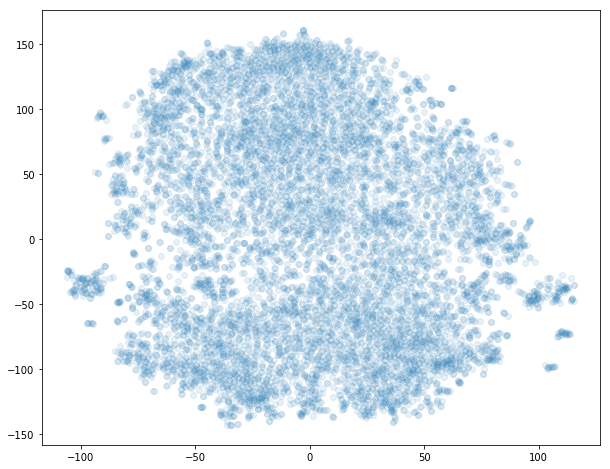

In [15]:
fig, ax = plt.subplots(figsize=(10, 8)) 
ax.scatter(df.x, df.y, alpha=.1);
# Make points translucent so we can visually identify regions with a high density 

### Evaluation of t-sne
A good sanity check is to identify some groups of movies that we strongly believe should be close together, and see whether they're close in the 2-d space.

For example, all the Harry Potter movies should be close together.

#### Plot all movies whose titles contain 'pattern'

In [6]:
df = pd.read_csv('movies_tsne.csv', index_col=0)
df.head()

,movieId,title,genres,key,year,n_ratings,mean_rating,x,y
0,0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995,49695,3.921240,-100.317540,-29.516657
1,1,Jumanji,Adventure|Children|Fantasy,Jumanji,1995,22243,3.211977,20.766030,-132.111970
2,2,Grumpier Old Men,Comedy|Romance,Grumpier Old Men,1995,12735,3.151040,65.842476,-50.610844
3,3,Waiting to Exhale,Comedy|Drama|Romance,Waiting to Exhale,1995,2756,2.861393,12.194196,-109.000400
4,4,Father of the Bride Part II,Comedy,Father of the Bride Part II,1995,12161,3.064592,-62.635260,-112.672800


In [7]:
embs = df.loc[:,['x','y']].to_numpy()
embs[:5]

array([[-100.31754 ,  -29.516657],
       [  20.76603 , -132.11197 ],
       [  65.842476,  -50.610844],
       [  12.194196, -109.0004  ],
       [ -62.63526 , -112.6728  ]])

In [8]:
# Several helper functions for plotting annotated t-SNE visualizations
def plot_by_title_pattern(pattern, **kwargs):
    """Plot all movies whose titles contains 'pattern'.
    """
    match = df[df.title.str.contains(pattern)]  # all movies whose titles contains 'pattern'
    return plot_with_annotations(match.index, **kwargs)

def plot_with_annotations(label_indices, text=True, labels=None, alpha=1, **kwargs):
    ax = plot_bg(**kwargs)
    Xlabeled = embs[label_indices, 0]
    Ylabeled = embs[label_indices, 1]
    if labels is not None:
        for x, y, label in zip(Xlabeled, Ylabeled, labels):
            ax.scatter(x, y, alpha=alpha, label=label, marker='1', s=90)
        fig.legend()
    else:
        ax.scatter(Xlabeled, Ylabeled, alpha=alpha, color='green') # mark green for all movies whose titles contains 'pattern'
    
    if text:
        # TODO: Add abbreviated title column
        titles = mainstream_movies.loc[label_indices, 'title'].values
        texts = []
        for label, x, y in zip(titles, Xlabeled, Ylabeled):
            t = ax.annotate(label, xy=(x, y))                      # annotate with title 
            texts.append(t)
        
    return ax

def plot_bg(bg_alpha=.01, figsize=(13, 9), emb_2d=None):
    """Create and return a plot of all our movie embeddings with very low opacity.
    """
    if emb_2d is None:
        emb_2d = embs
    fig, ax = plt.subplots(figsize=figsize)
    X = emb_2d[:, 0]
    Y = emb_2d[:, 1]
    ax.scatter(X, Y, alpha=bg_alpha)
    return ax

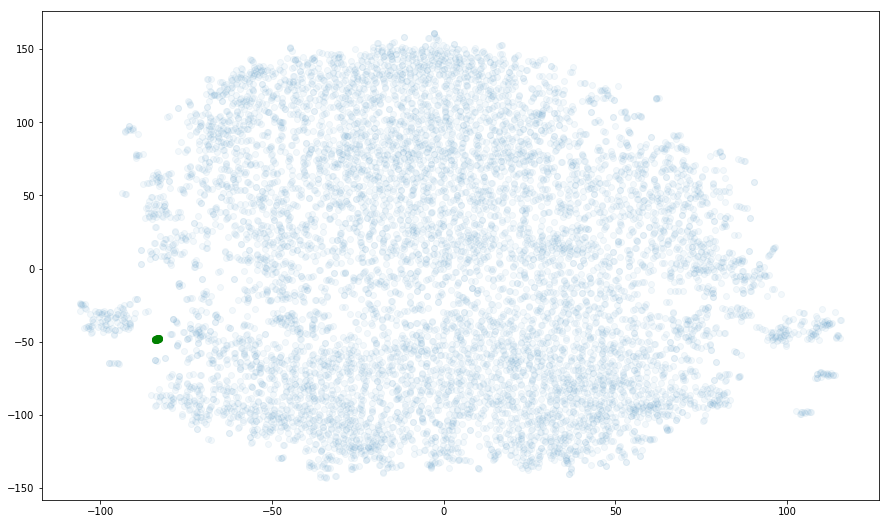

In [9]:
# plot a green dot for each of the 8 Harry Potter movies
plot_by_title_pattern('Harry Potter', figsize=(15, 9), bg_alpha=.05, text=False)

#### Take a closer look by only ploting region around one movie specified by its title

In [10]:
# Several helper functions for plotting region
def plot_region_around(title, margin=5, **kwargs):
    """Plot the region of the mapping space in the neighbourhood of the the movie with
    the given title. The margin parameter controls the size of the neighbourhood around
    the movie.
    """
    xmargin = ymargin = margin
    match = df[df.title == title]     # get the movie by its title
    assert len(match) == 1
    row = match.iloc[0]               # match only has one row, (row.x, row.y) is the 2D coordinate 
    return plot_region(row.x-xmargin, row.x+xmargin, row.y-ymargin, row.y+ymargin, **kwargs)
 
def plot_region(x0, x1, y0, y1, text=True):   
    """Plot the region of the mapping space bounded by the given x and y limits.
    """
    fig, ax = plt.subplots(figsize=(13, 9))
    pts = df[                          # datapoints inside of the region 
        (df.x >= x0) & (df.x <= x1)
        & (df.y >= y0) & (df.y <= y1)
    ]
    ax.scatter(pts.x, pts.y, alpha=.6) # plot the datapoints inside of the region
    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)
    if text:                           # annotate datapoints with their titles
        texts = []
        for label, x, y in zip(pts.title.values, pts.x.values, pts.y.values):
            t = ax.annotate(label, xy=(x, y))
            texts.append(t)
    return ax

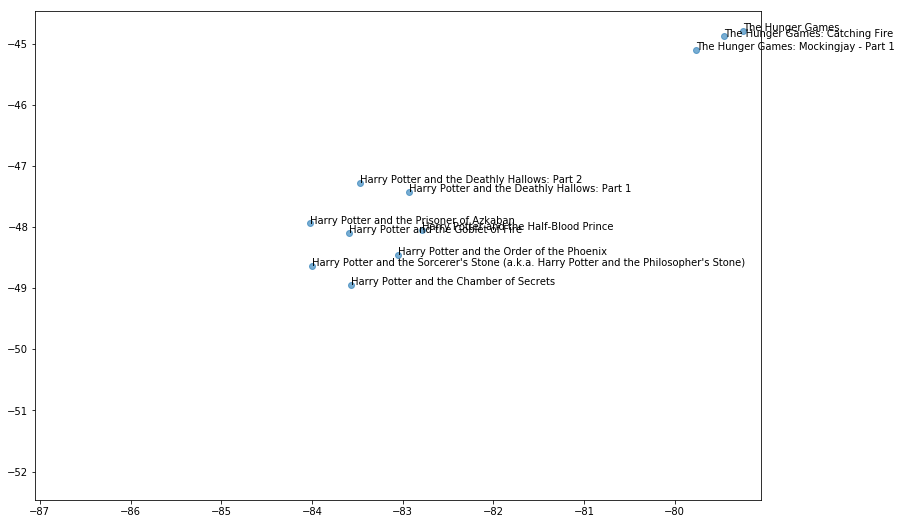

In [11]:
plot_region_around('Harry Potter and the Order of the Phoenix', 4);  
# 4 is the margin, which specify the size of the region around the movie to plot

#### Plot all Documentary movies 

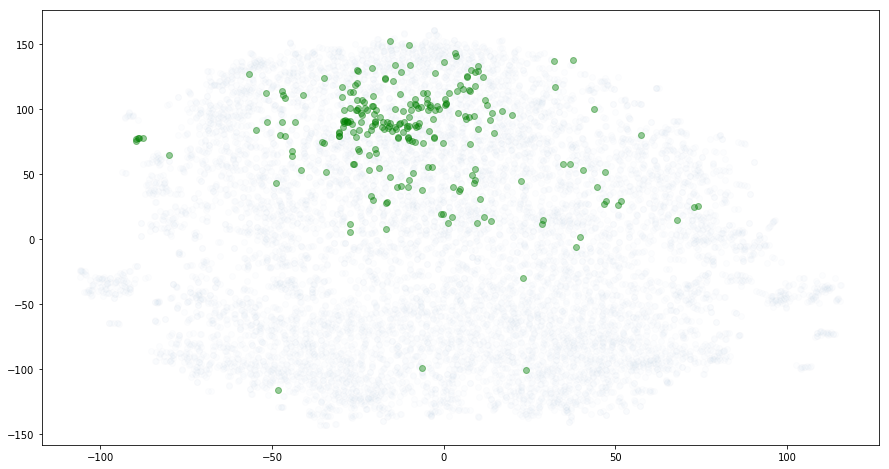

In [12]:
docs = df[ (df.genres == 'Documentary') ]
plot_with_annotations(docs.index, text=False, alpha=.4, figsize=(15, 8));

It's not a tight cluster, but there's definitely a strong pattern here.<br />
Note that we never actually showed genre as a feature to the model.

#### Plot movies whose genres are a subset of {Comedy, Drama, Romance}

In [13]:
import itertools
genre_components = ['Comedy', 'Drama', 'Romance']
genre_combos = set()
for size in range(1, 4):
    combo_strs = ['|'.join(genres) for genres in itertools.combinations(genre_components, size)]
    genre_combos.update(combo_strs)
genre_combos

dromcoms = df[df.genres.isin(genre_combos)]

{'Comedy',
 'Comedy|Drama',
 'Comedy|Drama|Romance',
 'Comedy|Romance',
 'Drama',
 'Drama|Romance',
 'Romance'}

In [17]:
dromcoms

,movieId,title,genres,key,year,n_ratings,mean_rating,x,y
2,2,Grumpier Old Men,Comedy|Romance,Grumpier Old Men,1995,12735,3.151040,65.842476,-50.610844
3,3,Waiting to Exhale,Comedy|Drama|Romance,Waiting to Exhale,1995,2756,2.861393,12.194196,-109.000400
4,4,Father of the Bride Part II,Comedy,Father of the Bride Part II,1995,12161,3.064592,-62.635260,-112.672800
6,6,Sabrina,Comedy|Romance,Sabrina (1995),1995,12961,3.366484,-79.072950,-95.665276
10,10,The American President,Comedy|Drama|Romance,The American President,1995,18162,3.667713,-75.032800,19.783434
13,13,Nixon,Drama,Nixon,1995,6022,3.432082,49.294598,75.800934
16,16,Sense and Sensibility,Drama|Romance,Sense and Sensibility,1995,20667,3.968573,-83.194570,59.607056
17,17,Four Rooms,Comedy,Four Rooms,1995,5203,3.373631,38.645645,-37.061253
18,18,Ace Ventura: When Nature Calls,Comedy,Ace Ventura: When Nature Calls,1995,20938,2.607412,-34.301376,-143.039370
24,24,Leaving Las Vegas,Drama|Romance,Leaving Las Vegas,1995,21553,3.689510,58.648106,74.425560


In [15]:
def add_annotations(ax, label_indices, emb_2d=None, **kwargs):
    """plot dataponits specified by label_indices, with properties specified by **kwargs"""
    if emb_2d is None:
        emb_2d = embs
    X = emb_2d[label_indices, 0]
    Y = emb_2d[label_indices, 1]
    ax.scatter(X, Y, **kwargs)

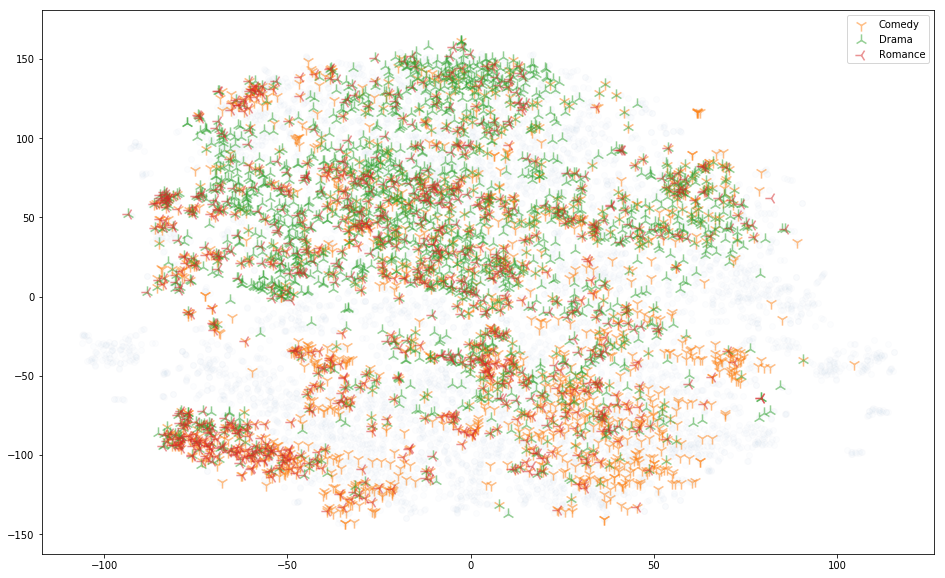

In [16]:
ax = plot_bg(figsize=(16, 10))
for i, genre in enumerate(genre_components):
    m = dromcoms[dromcoms.genres.str.contains(genre)] # movies whose genres contains <genre>
    marker = str(i+1)                                 # each genre has a different marker
    add_annotations(ax, m.index, label=genre, alpha=.5, marker=marker, s=150, linewidths=5)
plt.legend();